In [1]:
# wspinaczka part 1
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import plot

In [2]:
data_path = "./dane/"
df = pd.read_csv(os.path.join(data_path, "dane_spr1.csv"), sep=';')

In [3]:
# KR to wartość naszego rozwiązania - ma być najmniejsza
def get_KR(df = df):
    c_sum = df["Czas wykonania"].cumsum() # suma kumultatywna kolumny "Czas wykonania"
    KR = (df["Termin"] - c_sum)**2 # obliczanie kwadratu różnicy wartosći
    return sum(KR) # KR jest wskaźnikiem jakości ułożenia zadań. To optymalizujemy

# wyszukiwanie listy sąsiadów
def get_neighbours(idx, neighbours_count = 10, df = df):
    N = neighbours_count
    # Idea sąsiedztwa dla N = 6 i idx = n E <N/2 ; L-N/2>
    # idx = X, sąsiad = 0, nie sąsiad = -
    # nr_indeksu | ... | n-4 | n-3 | n-2 | n-1 |  n  | n+1 | n+2 | n+3 | n+4 | ... |
    # sasiedztwo |  -  |  -  |  0  |  0  |  0  |  X  |  0  |  0  |  0  |  -  |  -  |
    
    L = len(df) - 1 
    idx_prev = idx # indeks dla ktorego szukamy sasiadow
    N_half = N//2 # polowa wartosci N
    
    
    # Idea sąsiedztwa dla N = 6 i idx = n < N/2
    # idx = X, sąsiad = 0, nie sąsiad = -
    # przykład n = 2
    # nr_indeksu |  0  |  1  | n=2 |  3  |  4  |  5  |  6  |  7  |  8  |  9  | ... |
    # sasiedztwo |  0  |  0  |  X  |  0  |  0  |  0  |  0  |  -  |  -  |  -  |  -  |
    # skoro nie mozemy znaleźć wystarczająco dużo sąsiadów po lewej, 
    # szukamy dodatkowego po prawej
    if idx < N_half:
        idx = N_half
    # idea sąsiedztwa z ograniczeniem z prawej jest analogiczna do tej z ograniczeniem z lewej
    elif idx > L - N_half:
        idx = L - N_half
    output = list(range(idx - N_half, idx + N_half + 1))
    # usuwanie idx z output
    # TODO: na pewno da się to zrobić prościej
    rm_idx = output.index(idx_prev)
    output = np.array(output)
    output = np.delete(output, rm_idx)
    return output

def calculate_improvements(KR_before, idx, neighbours, improvements, df = df):
    for neighbour, improvement in zip(
        neighbours, 
        np.nditer(improvements, op_flags = ['readwrite'])
    ):
        swap(idx, neighbour)
        improvement[...] = np.float64(get_KR() - KR_before)
        swap(idx, neighbour)
        
def search_for_the_best_neighbour(neighbours, improvements):
    if improvements.min() > 0:
        return False
    idx_min = improvements.argmin() # index najmniejszego elementu
    return neighbours[idx_min]

def swap(idx_1, idx_2, df=df):
    # zamiana miejscami dwóch wierszy "in place" - nie tworzymy nowej ramki danych
    df.iloc[idx_1], df.iloc[idx_2] = df.iloc[idx_2].copy(), df.iloc[idx_1].copy()
    
def move(idx_1, idx_2, df=df):
    swap(idx_1, idx_2) # ruch
    
def plot_optimalization(optimalization):
    # TODO: można to zrobić ładniej matplotlibem
    optimalization["Wartosc kombinacji"].plot(kind="line")

In [6]:
np.random.seed(42)

def hill_climbing_algorithm(
    number_of_iterations = 1000, 
    break_counter = 10, 
    neighbours_count = 20,
    starting_index = np.random.randint(len(df))
):
    KR_before = get_KR() # początkowa wartość kombinacji
    optimalization = pd.DataFrame(columns=["Wartosc kombinacji"])
    optimalization = optimalization.append({
                    "Wartosc kombinacji": KR_before
                }, ignore_index=True)
    improvements = np.zeros(neighbours_count)
    idx = starting_index
    
    while number_of_iterations and break_counter:
        neighbours = get_neighbours(idx, neighbours_count=neighbours_count) # lista sąsiadów
        # obliczanie potencjalnych ulepszeń dla sąsiadów
        calculate_improvements(KR_before, idx, neighbours, improvements)
        # wyszukanie sąsiada dla którego ulepszenie będzie największe
        best_neighbour = search_for_the_best_neighbour(neighbours, improvements)

        # jeżeli istnieje sąsiad po zamianie z którym ulepszymy kombinacje
        if best_neighbour:
            # zamiana miejscami z sąsiadem
            move(idx, best_neighbour)
            # obliczanie obecnej kombinacji
            KR_now = get_KR()
            # kolejna iteracja rozpoczyna się od miejsca na które wskoczył idx
            idx = best_neighbour  
            # dodawanie obecnej wartości kombinacji do listy wszystkich wartości
            optimalization = optimalization.append({
                "Wartosc kombinacji": KR_now
            }, ignore_index=True)
            
            KR_before = KR_now
            number_of_iterations -= 1
        else:
            break_counter -= 1
            
    order = df["Zadanie"]
    
    return order, optimalization

205111018

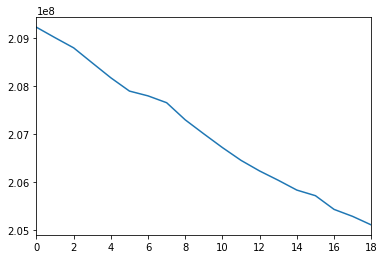

In [7]:
if __name__ == '__main__':
    new_order, new_optimalization = hill_climbing_algorithm(
            number_of_iterations=500,
            break_counter=20,
            neighbours_count=20
        )
    plot_optimalization(new_optimalization)
    new_optimalization["Wartosc kombinacji"].iloc[-1]